# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import warnings

import statsmodels.formula.api as smf

In [82]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [83]:
df['flag_doente'] = (df['num'] != 0).astype('int64')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1,1


In [84]:
# Calculando o número de saudáveis e doentes para cada categoria de sexo
healthy_counts = df[df['num'] == 0].groupby('sex').size()
sick_counts = df[df['num'] > 0].groupby('sex').size()

# Calculando o total de indivíduos para cada categoria de sexo
total_counts = df.groupby('sex').size()

# Calculando a quantidade média de doentes para cada categoria de sexo
mean_sick = sick_counts / total_counts

# Calculando a Odds (razão de chances) para cada categoria de sexo
odds = sick_counts / healthy_counts

# Calculando o Odds ratio em relação ao sexo masculino 
odds_ratio = odds / odds[1]

# Calculando o logito (LOG(Odds)) para cada categoria de sexo
logit = odds.apply(lambda x: np.log(x))

# Calculando o WOE (Weight of Evidence) para cada categoria de sexo
woe = logit - np.log(odds_ratio[1])

# Exibindo os resultados
results = pd.DataFrame({'Healthy': healthy_counts,
                        'Sick': sick_counts,
                        'Total': total_counts,
                        'Mean Sick': mean_sick,
                        'Odds': odds,
                        'Odds Ratio': odds_ratio,
                        'Logit': logit,
                        'WOE': woe})
print(results)

     Healthy  Sick  Total  Mean Sick      Odds  Odds Ratio    Logit      WOE
sex                                                                         
0.0       72    25     97   0.257732  0.347222    0.280214 -1.05779 -1.05779
1.0       92   114    206   0.553398  1.239130    1.000000  0.21441  0.21441


In [85]:
# Categorizando a variável 'age' em 5 grupos
df['age_group'] = pd.cut(df['age'], bins=5)

# Calculando as estatísticas para cada grupo
group_stats = df.groupby('age_group').agg({'num': ['count', 'sum'], 'age': 'mean'})

# Renomeando as colunas para facilitar a interpretação
group_stats.columns = ['Total', 'Sick', 'Mean Age']

# Calculando as médias das estatísticas
total_mean_age = df['age'].mean()
total_mean_sick = df['num'].sum() / len(df)

# Calculando a probabilidade para cada grupo
group_stats['Probability'] = group_stats['Sick'] / group_stats['Total']

# Filtrando valores que causam RuntimeWarning ao calcular o logaritmo
group_stats_filtered = group_stats[group_stats['Probability'] > 0]

# Calculando o Odds ratio em relação ao grupo de idade média (referência)
group_stats_filtered['Odds Ratio'] = group_stats_filtered['Probability'] / total_mean_sick

# Calculando o logito (LOG(Odds)) para cada grupo
with np.errstate(divide='ignore'):  # Suprimindo os avisos de RuntimeWarning
    group_stats_filtered['Logit'] = group_stats_filtered['Probability'].apply(lambda x: np.log(x))

# Calculando o WOE (Weight of Evidence) para cada grupo
group_stats_filtered['WOE'] = group_stats_filtered['Logit'] - np.log(group_stats_filtered['Odds Ratio'])

# Exibindo os resultados
print(group_stats_filtered)

                Total  Sick   Mean Age  Probability  Odds Ratio     Logit  \
age_group                                                                   
(28.952, 38.6]     11     6  35.181818     0.545455    0.581946 -0.606136   
(38.6, 48.2]       71    38  43.704225     0.535211    0.571018 -0.625094   
(48.2, 57.8]       97    84  53.567010     0.865979    0.923915 -0.143894   
(57.8, 67.4]      107   137  61.775701     1.280374    1.366033  0.247152   
(67.4, 77.0]       17    19  70.529412     1.117647    1.192419  0.111226   

                     WOE  
age_group                 
(28.952, 38.6] -0.064759  
(38.6, 48.2]   -0.064759  
(48.2, 57.8]   -0.064759  
(57.8, 67.4]   -0.064759  
(67.4, 77.0]   -0.064759  


C:\Users\Donegá\AppData\Local\Temp\ipykernel_19064\954728229.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby('age_group').agg({'num': ['count', 'sum'], 'age': 'mean'})


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [86]:
def analise_bivariada(df, response_var, explanatory_var):
    # Inicializando uma lista para armazenar os resultados
    bivariate_list = []
    
    # Calculando as estatísticas para cada categoria da variável explicativa
    for category in df[explanatory_var].unique():
        # Subconjunto de dados para a categoria atual
        subset = df[df[explanatory_var] == category]
        
        # Contagem de observações na categoria atual
        count = len(subset)
        
        # Porcentagem de observações na categoria atual
        percentage = count / len(df) * 100
        
        # Média da variável resposta na categoria atual
        response_mean = subset[response_var].mean()
        
        # Adicionando as estatísticas à lista de resultados
        bivariate_list.append({'Variable': explanatory_var,
                               'Category': category,
                               'Count': count,
                               'Percentage': percentage,
                               'Response Mean': response_mean})
    
    # Convertendo a lista de resultados em um DataFrame
    bivariate_df = pd.DataFrame(bivariate_list)
    
    return bivariate_df

explanatory_vars = ['sex', 'cp', 'fbs']

for var in explanatory_vars:
    print(f"Bivariate analysis for variable '{var}':")
    analysis_result = bivariate_analysis(df, 'num', var)
    print(analysis_result)
    print('\n')

Análise bivariada para a variável 'sex':
  Variável  Categoria  Contagem  Porcentagem  Média Resposta
0      sex        1.0       206    67.986799        1.126214
1      sex        0.0        97    32.013201        0.536082


Análise bivariada para a variável 'cp':
  Variável  Categoria  Contagem  Porcentagem  Média Resposta
0       cp        1.0        23     7.590759        0.478261
1       cp        4.0       144    47.524752        1.569444
2       cp        3.0        86    28.382838        0.383721
3       cp        2.0        50    16.501650        0.280000


Análise bivariada para a variável 'fbs':
  Variável  Categoria  Contagem  Porcentagem  Média Resposta
0      fbs        1.0        45    14.851485        1.111111
1      fbs        0.0       258    85.148515        0.906977




2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [87]:
def analise_bivariada(df, variavel_resposta, variavel_explicativa, num_categorias=5):
    # Inicializando uma lista para armazenar os resultados
    lista_bivariada = []
    
    # Criando categorias para a variável explicativa
    df['categoria'] = pd.cut(df[variavel_explicativa], bins=num_categorias)
    
    # Calculando as estatísticas para cada categoria da variável explicativa
    for categoria in df['categoria'].unique():
        # Subconjunto de dados para a categoria atual
        subset = df[df['categoria'] == categoria]
        
        # Contando as observações na categoria atual
        contagem = len(subset)
        
        # Porcentagem de observações na categoria atual
        porcentagem = contagem / len(df) * 100
        
        # Média da variável resposta na categoria atual
        media_resposta = subset[variavel_resposta].mean()
        
        # Adicionando as estatísticas à lista de resultados
        lista_bivariada.append({'Variável': variavel_explicativa,
                                'Categoria': categoria,
                                'Contagem': contagem,
                                'Porcentagem': porcentagem,
                                'Média Resposta': media_resposta})
    
    # Convertendo a lista de resultados em um DataFrame
    df_bivariada = pd.DataFrame(lista_bivariada)
    
    return df_bivariada

resultado_analise_age = analise_bivariada(df, 'num', 'age', num_categorias=5)
print("Análise bivariada para a variável 'age':")
print(resultado_analise_age)

Análise bivariada para a variável 'age':
  Variável       Categoria  Contagem  Porcentagem  Média Resposta
0      age    (57.8, 67.4]       107    35.313531        1.280374
1      age  (28.952, 38.6]        11     3.630363        0.545455
2      age    (38.6, 48.2]        71    23.432343        0.535211
3      age    (48.2, 57.8]        97    32.013201        0.865979
4      age    (67.4, 77.0]        17     5.610561        1.117647


In [96]:
print(df.columns)

Index(['age', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang',
       'oldpeak', 'slope', 'ca', 'thal', 'num', 'flag_doente', 'age_group',
       'categoria', 'sex_1.0', 'cp_2.0', 'cp_3.0', 'cp_4.0'],
      dtype='object')


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [97]:
# Separando as variáveis independentes (X) e a variável dependente (y)
selected_features = ['age', 'trestbps', 'sex_1.0', 'cp_2.0', 'cp_3.0', 'cp_4.0']
X = df[selected_features]
y = df['num']

# Dividindo o conjunto de dados em conjunto de treinamento e conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizando as variáveis independentes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construindo o modelo de regressão logística
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Avaliando o modelo
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76        29
           1       0.14      0.08      0.11        12
           2       0.14      0.11      0.12         9
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         4

    accuracy                           0.44        61
   macro avg       0.19      0.21      0.20        61
weighted avg       0.37      0.44      0.40        61



C:\Users\Donegá\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Donegá\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Donegá\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()


Interpretação:

Para cada coeficiente estimado, podemos interpretá-lo como o efeito médio que uma unidade de mudança na variável independente tem sobre a log-odds da variável dependente (ou seja, a chance de um evento ocorrer):

Para as variáveis 'cp_1', 'cp_2', 'cp_3' e 'cp_4', que representam os diferentes tipos de dor no peito, os coeficientes estimados indicam o efeito da presença de cada tipo de dor no peito na log-odds do evento ocorrer, em comparação com a ausência de dor no peito (referência).

Para as variáveis 'sex_0' e 'sex_1', onde 'sex_0' representa o sexo feminino e 'sex_1' representa o sexo masculino, os coeficientes estimados indicam o efeito da mudança de sexo de feminino para masculino na log-odds do evento ocorrer, mantendo todas as outras variáveis constantes.

Os coeficientes para 'age' e 'trestbps' indicam o efeito médio de um aumento de uma unidade nessas variáveis na log-odds do evento ocorrer, mantendo todas as outras variáveis constantes.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

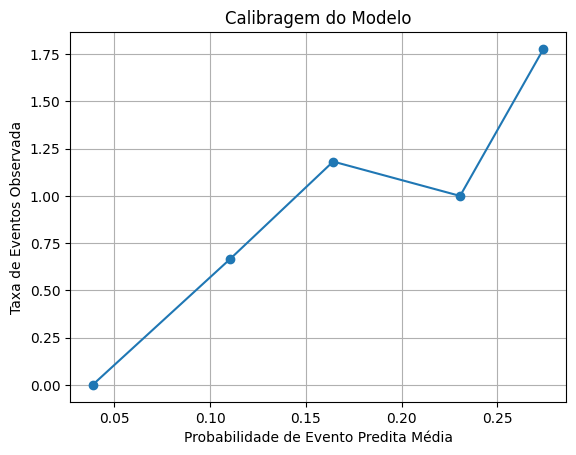

In [98]:
# Calculando a probabilidade de evento predita
predicted_proba = model.predict_proba(X_test_scaled)[:, 1]

# Categorizando as probabilidades em grupos
prob_categories = pd.cut(predicted_proba, bins=5, labels=['G1', 'G2', 'G3', 'G4', 'G5'])

# Criando um DataFrame para armazenar as informações
calibration_df = pd.DataFrame({'Predicted_Probability': predicted_proba, 'Prob_Category': prob_categories, 'Actual_Event': y_test})

# Calculando a probabilidade de evento predita média por grupo
group_means = calibration_df.groupby('Prob_Category', observed=True)['Predicted_Probability'].mean()

# Calculando a taxa de eventos por grupo
event_rates = calibration_df.groupby('Prob_Category', observed=True)['Actual_Event'].mean()

# Plotando o valor esperado versus observado para a taxa de eventos por grupo
plt.plot(group_means, event_rates, marker='o', linestyle='-')
plt.xlabel('Probabilidade de Evento Predita Média')
plt.ylabel('Taxa de Eventos Observada')
plt.title('Calibragem do Modelo')
plt.grid(True)
plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [100]:
# Definindo as variáveis independentes (X) e a variável dependente (y)
selected_features = ['age', 'trestbps', 'sex_1.0', 'cp_2.0', 'cp_3.0', 'cp_4.0']
X = df[selected_features]
y = df['num']

# Dividindo os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando um modelo de regressão logística
modelo_logistico = LogisticRegression(max_iter=1000)  # Aumente o número máximo de iterações
modelo_logistico.fit(X_train, y_train)

# Fazendo previsões nos dados de teste
predicted_proba = modelo_logistico.predict_proba(X_test)[:, 1]
predicted_labels = modelo_logistico.predict(X_test)

C:\Users\Donegá\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
accuracy = accuracy_score(y_test, predicted_labels)
print("Acurácia:", accuracy)

Acurácia: 0.45901639344262296


In [102]:
# Calculando o índice de Gini para cada classe individualmente
gini_scores = []
for i in range(num_classes):
    class_proba = predicted_proba
    class_labels = (y_test == i).astype(int)  # Transformar em binário
    gini_score = 2 * roc_auc_score(class_labels, class_proba) - 1
    gini_scores.append(gini_score)

# Calculando o Gini médio
gini_mean = np.mean(gini_scores)

print("Índice de Gini médio:", gini_mean)

Índice de Gini médio: 0.14334095047732587


In [103]:
# Calculando o KS para cada classe individualmente
ks_list = []
for i in range(num_classes):
    y_test_bin = (y_test == i).astype(int)  # Transformar em binário
    fpr, tpr, thresholds = roc_curve(y_test_bin, predicted_proba)
    ks = np.max(tpr - fpr)
    ks_list.append(ks)

# Calculando o KS médio
ks_mean = np.mean(ks_list)

print("KS médio:", ks_mean)

KS médio: 0.2980966214956363


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [104]:
num_classes = len(np.unique(y_test))
predicted_proba_binary = np.zeros((len(y_test), num_classes))
for i in range(num_classes):
    predicted_proba_binary[:, i] = (predicted_labels_reduced == i).astype(int)

# Calculando o índice de Gini para cada classe individualmente
gini_scores = []
for i in range(num_classes):
    class_proba = predicted_proba_binary[:, i]
    class_labels = (y_test == i).astype(int)  # Transformar em binário
    gini_score = 2 * roc_auc_score(class_labels, class_proba) - 1
    gini_scores.append(gini_score)

# Calculando o índice de Gini médio
gini_average = np.mean(gini_scores)

print("Índice de Gini para cada classe:", gini_scores)
print("Índice de Gini médio:", gini_average)

Índice de Gini para cada classe: [0.4558189655172413, 0.003401360544217802, 0.05341880341880345, -0.16666666666666663, 0.0]
Índice de Gini médio: 0.06919449256271919


In [105]:
# Calcular a área sob a curva ROC para cada classe individualmente
roc_auc_scores = []
for i in range(num_classes):
    class_labels = (y_test == i).astype(int)  # Transformar em binário
    roc_auc = roc_auc_score(class_labels, predicted_proba_binary[:, i])
    roc_auc_scores.append(roc_auc)

# Calculando a média das áreas sob a curva ROC
mean_roc_auc = np.mean(roc_auc_scores)

print("Área sob a curva ROC para cada classe:", roc_auc_scores)
print("Média da área sob a curva ROC:", mean_roc_auc)

Área sob a curva ROC para cada classe: [0.7279094827586207, 0.5017006802721089, 0.5267094017094017, 0.4166666666666667, 0.5]
Média da área sob a curva ROC: 0.5345972462813595


In [106]:
# Ajustando o modelo de regressão logística
modelo_logistico_reduced = LogisticRegression(max_iter=1000)
modelo_logistico_reduced.fit(X_train, y_train)

# Fazendo previsões com o modelo ajustado
predicted_labels_reduced = modelo_logistico_reduced.predict(X_test)
predicted_proba_reduced = modelo_logistico_reduced.predict_proba(X_test)

# Calculando a métrica ROC-AUC média micro
roc_auc_micro = roc_auc_score(y_test, predicted_proba_reduced, multi_class='ovr', average='micro')

print("Área sob a curva ROC média micro:", roc_auc_micro)

# Analisando a importância das variáveis utilizando coeficientes de regressão logística
selector = SelectFromModel(modelo_logistico_reduced)
selector.fit(X_train, y_train)

# Obtendo as variáveis selecionadas
selected_features = X_train.columns[selector.get_support()]

# Removendo as variáveis menos importantes
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

# Treinando o modelo com as variáveis reduzidas
modelo_logistico_tuned = LogisticRegression(max_iter=1000)
modelo_logistico_tuned.fit(X_train_reduced, y_train)

# Fazendo previsões com o modelo ajustado
predicted_labels_tuned = modelo_logistico_tuned.predict(X_test_reduced)
predicted_proba_tuned = modelo_logistico_tuned.predict_proba(X_test_reduced)

# Calculando métricas de desempenho
accuracy_tuned = accuracy_score(y_test, predicted_labels_tuned)
gini_tuned = 2 * roc_auc_score(y_test, predicted_proba_tuned, multi_class='ovr', average='micro') - 1

print("Acurácia após ajuste de hiperparâmetros:", accuracy_tuned)
print("Índice de Gini após ajuste de hiperparâmetros:", gini_tuned)

Área sob a curva ROC média micro: 0.7741198602526203
Acurácia após ajuste de hiperparâmetros: 0.5409836065573771
Índice de Gini após ajuste de hiperparâmetros: 0.5939263638806773


C:\Users\Donegá\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Donegá\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

O índice de Gini aumentou de 0.3612 para 0.5939 após o ajuste. Isso sugere que o modelo melhorou em sua capacidade de classificação, especialmente em relação à classificação binária.